# **Import**

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report
import seaborn as sns
import os, shutil
from sklearn.utils import shuffle

# **Enable GPU**

In [53]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  # Currently, memory growth needs to be the same across GPUs
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# **Paths**

In [54]:
# Paths
dataset_dir = '../VegetableImages'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
valid_dir = os.path.join(dataset_dir, 'validation')

# Dataframe path
df_path = '../CSV/'

# **Plot some data**

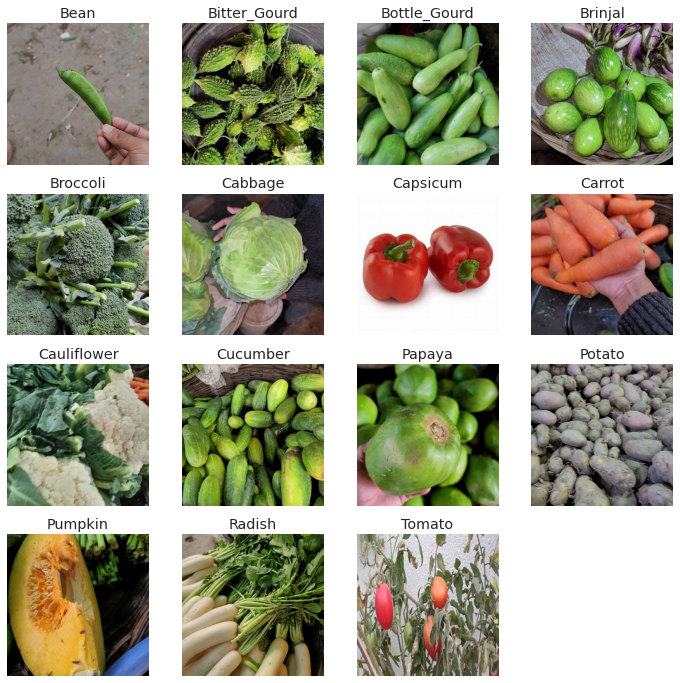

In [55]:
def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_dir + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
image_categories = os.listdir(train_dir)
plot_images(image_categories)

# **Load dataframes**

In [56]:
train_df = pd.read_csv(df_path + '/' + 'trainset.csv')
val_df = pd.read_csv(df_path + '/' + 'valset.csv')
test_df = pd.read_csv(df_path + '/' + 'testset.csv')
all_df = pd.read_csv(df_path + '/' + 'dataset.csv')

# Print the class encodings done by the generators
print()
class_map = dict([(i, cat) for i, cat in enumerate(os.listdir(train_dir))])
print("Dataset classes:")
print(class_map)


Dataset classes:
{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


# **Split Dataset**

In [57]:
# train_part, rem_part = train_test_split(all_df, train_size=0.70)
# val_part, test_part = train_test_split(rem_part, test_size=0.50)

train_part = train_df
val_part = val_df
test_part = test_df

X_train = train_part.iloc[:, 0].values
y_train = train_part.iloc[:, 1].values
X_val = val_part.iloc[:, 0].values
y_val = val_part.iloc[:, 1].values
X_test = test_part.iloc[:, 0].values
y_test = test_part.iloc[:, 1].values
allData = all_df.iloc[:, 0].values


print("Number of images in training set: ", len(X_train))
print("Number of images in validation set: ", len(X_val))
print("Number of images in testing set: ", len(X_test))
print("Total Number of images in dataset: ", len(allData))

Number of images in training set:  15000
Number of images in validation set:  3000
Number of images in testing set:  3000
Total Number of images in dataset:  21000


In [58]:
## Important parameters
imageSize = 150
batchSize = 64
seedNum = 42
classificationMode = 'raw'

In [59]:
# Creating Image Data Generator for train, validation and test set

normalizer = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
Column_X = 'Imagepath'
Coulmn_Y = 'Label'
# 1. Train Set
trainSet = normalizer.flow_from_dataframe(dataframe = train_part,
                                        x_col=Column_X,
                                        y_col=Coulmn_Y,
                                        target_size=(imageSize, imageSize),
                                        batch_size=batchSize, 
                                        seed=seedNum,
                                        class_mode=classificationMode)

# 2. Validation Set
valSet = normalizer.flow_from_dataframe(dataframe = val_part,
                                    x_col=Column_X,
                                    y_col=Coulmn_Y,
                                    target_size=(imageSize, imageSize),
                                    batch_size=batchSize, 
                                    seed=seedNum,
                                    class_mode=classificationMode)

# 3. Test Set
testSet = normalizer.flow_from_dataframe(dataframe = test_part,
                                        x_col=Column_X,
                                        y_col=Coulmn_Y,
                                        target_size=(imageSize, imageSize),
                                        batch_size=batchSize, 
                                        seed=seedNum,
                                        class_mode=classificationMode)

Found 15000 validated image filenames.
Found 3000 validated image filenames.
Found 3000 validated image filenames.


# **Build & Compile model**

In [60]:
# Build a sequential CNN model

model = Sequential() # model object

# Add Layers
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[imageSize, imageSize, 3]))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

# Flatten the feature map
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dense(15, activation='softmax'))

# print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 128)     

In [61]:
# Compile and fit the model

# Custom learning_rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics='accuracy')

hist = model.fit(trainSet,
                 epochs=20, 
                 verbose=1, 
                 validation_data=valSet, 
                 steps_per_epoch = len(X_train)//batchSize, 
                 validation_steps = len(X_val)//batchSize)


# Predict the accuracy for the test set
scores = model.evaluate(testSet)
print()
print("%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/20
234/234 [==============================] - 26s 108ms/step - loss: 1.6696 - accuracy: 0.4415 - val_loss: 1.1089 - val_accuracy: 0.6151
Epoch 2/20
234/234 [==============================] - 26s 110ms/step - loss: 0.7502 - accuracy: 0.7519 - val_loss: 0.5287 - val_accuracy: 0.8173
Epoch 3/20
234/234 [==============================] - 23s 98ms/step - loss: 0.4609 - accuracy: 0.8476 - val_loss: 0.3025 - val_accuracy: 0.9100
Epoch 4/20
234/234 [==============================] - 22s 94ms/step - loss: 0.3052 - accuracy: 0.9051 - val_loss: 0.2396 - val_accuracy: 0.9266
Epoch 5/20
234/234 [==============================] - 22s 95ms/step - loss: 0.2148 - accuracy: 0.9359 - val_loss: 0.2591 - val_accuracy: 0.9178
Epoch 6/20
234/234 [==============================] - 22s 94ms/step - loss: 0.1643 - accuracy: 0.9502 - val_loss: 0.1934 - val_accuracy: 0.9372
Epoch 7/20
234/234 [==============================] - 22s 94ms/step - loss: 0.1395 - accuracy: 0.9582 - val_loss: 0.1949 - val_accurac

# **Plots and tests**

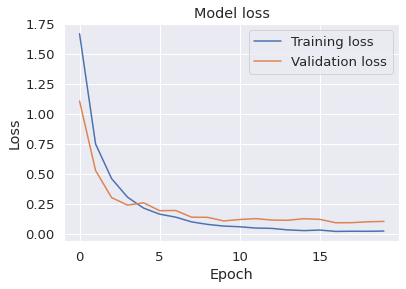

In [63]:
################### Loss Curve
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')
plt.show()

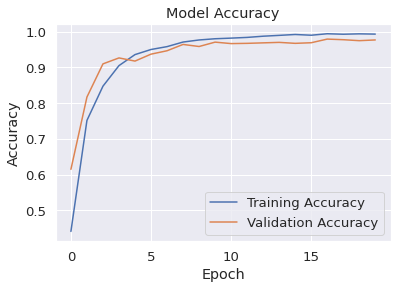

In [64]:
################### Accuracy Curve
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

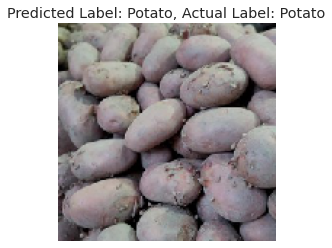

In [66]:
# Testing the Model
def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(imageSize, imageSize))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    
    # 3. Plot image
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
test_image_path = '../VegetableImages/test/Potato/1008.jpg'
actualClass = all_df.loc[all_df.Imagepath==test_image_path, 'Label'].values[0]

generate_predictions(test_image_path, actual_label=class_map[actualClass])

# **Saving model**

In [67]:
model.save("../TrainedModels/latestModelAfterEnhance.h5")

In [68]:
# To free GPU Memory
# from numba import cuda
# cuda.select_device(0)
# cuda.close()